In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

C:\Users\sandy\AppData\Local\Temp\ipykernel_9952\3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
#import numpy
import numpy as np

In [3]:
#import pandas
import pandas as pd
#read the pickled datafram
pickledDataFrameFileAddress="D:/Mars/MachineLearning/Datasets/ML dataset/ReducedDataset/unified22MineralsinlierTrainingDatatset.pkl"
datasetDataFrame=pd.read_pickle(pickledDataFrameFileAddress)

#retrieve the labels and spectra for hydrated silica
allSpectra=datasetDataFrame['Spectra'].to_numpy()
allSpectra=np.vstack(allSpectra)
allLabels=datasetDataFrame['classLabels'].to_numpy()
allNames=datasetDataFrame['classNames'].to_numpy()
#compute a list containing the labels and names of all minerals
uniqueLabels=np.unique(allLabels)
mineralNames=[]
for i in uniqueLabels:
    mineralNames.append(allNames[np.where(allLabels==i)][0])
mineralNames=np.array(mineralNames)
#remove the used variable from memory
del allNames
del datasetDataFrame
del pickledDataFrameFileAddress
del pd
del allSpectra
del allLabels

In [4]:
#load the trained model and weibull parameters
def loadOpenModel():
    #set the address of the trained model
    trainedModelAddress="D:/Mars/MachineLearning/topologicalClustering/openSetExperiments/trainedModels/SVC_withPlattScaling_ensembled_FeatureSubsample.sav"
    import pickle
    #save the model to the given address
    classifier=pickle.load(open(trainedModelAddress,'rb'))
    #set the addresses where the calibration outputs are to be saved
    calibrationActualLabelsAddress="D:/Mars/MachineLearning/topologicalClustering/openSetExperiments/crossValidationResults/SVMwithPlattScaling_ensembled_FeatureSubsample_CalibrationPredictedLabels.npy"
    calibrationPredictedLabelsAddress="D:/Mars/MachineLearning/topologicalClustering/openSetExperiments/crossValidationResults/SVMwithPlattScaling_ensembled_FeatureSubsample_CalibrationPredictedLabels.npy"
    calibrationPredictedDecisionFunctionAddress="D:/Mars/MachineLearning/topologicalClustering/openSetExperiments/crossValidationResults/SVMwithPlattScaling_ensembled_FeatureSubsample_AllClass_CalibrationPredictedDecision.npy"
    #save the three arrays
    calibrationActualLabels=np.load(calibrationActualLabelsAddress)
    calibrationPredictedLabels=np.load(calibrationPredictedLabelsAddress)
    calibrationPredictedDecisionFunction=np.load(calibrationPredictedDecisionFunctionAddress)
    calibrationPredictedDecisionFunction=calibrationPredictedDecisionFunction[np.arange(0,calibrationPredictedLabels.shape[0],1),
                                                                              calibrationPredictedLabels]

    #import Weibull distribution from scipy
    from scipy.stats import weibull_min as weibull
    classwiseTruePostiveWeibullParameters=[]
    #set the fraction of points that contsitute outliers
    fractionOfOutliers=0.1
    #create an array with all closed set labels
    uniqueLabels=np.arange(0,22,1)
    #iterate through all minerals
    for i in uniqueLabels:
        #get the probabilities of the false positives for the current mineral
        currentMineralTrueDecisionFunctions=calibrationPredictedDecisionFunction[np.logical_and(calibrationPredictedLabels==i,
                                                                                                calibrationActualLabels==i)]

        #set a minimum number of samples needed to fit weibull
        minimumNumberOfOutliers=int(fractionOfOutliers*currentMineralTrueDecisionFunctions.shape[0])

        #sort the array in ascending order
        currentMineralTrueDecisionFunctions.sort()
        #compute the firt and third quantiles
        firstQuantile,thirdQuantile=np.quantile(currentMineralTrueDecisionFunctions,
                                                [0.25,0.75])
        #retrieve the lower outliers i.e. < Q1-1.5IQR
        outlierTruePositiveDecisionFunctions=currentMineralTrueDecisionFunctions[currentMineralTrueDecisionFunctions<=(firstQuantile-1.5*(thirdQuantile-firstQuantile))]

        #if the number of samples above is less than the required number or equal to the total number of samples, retrive the 500 samples with the lowest probability
        if outlierTruePositiveDecisionFunctions.shape[0]<minimumNumberOfOutliers or outlierTruePositiveDecisionFunctions.shape[0]==currentMineralTrueDecisionFunctions.shape[0]:
            outlierTruePositiveDecisionFunctions=currentMineralTrueDecisionFunctions[:minimumNumberOfOutliers]


        #fit a Weibull distribution to the outliers and save the parameters
        classwiseTruePostiveWeibullParameters.append(weibull.fit(outlierTruePositiveDecisionFunctions))


    del calibrationActualLabels
    del calibrationPredictedLabels
    del calibrationPredictedDecisionFunction

    #return the model and weibull parameters
    return classifier,classwiseTruePostiveWeibullParameters

In [5]:
#read the wavelengthList
wavelengthListFileAddress="D:/Mars/MachineLearning/Datasets/ML dataset/wavelengthList.npy"
wavelengthList=np.load(wavelengthListFileAddress,allow_pickle=True)
del wavelengthListFileAddress

In [6]:
#set the address of the dictory cantaining the ML tookits datasets
mlToolkitDatasetsDirectory="D:/Mars/MachineLearning/Datasets/ML dataset"

In [7]:
'''</strong>Enter details of the image to be processed</strong>
<ol>
    <li>Address of the TRDR cube to be processed <code>crismDataCubeAddress</code> - similar to the Machine Learning toolkit TRR3 observations are used without applying corrections.</li>
    <li>Address of the standard RGB generated from the TRDR cube <code>fccFileAddress</code> - It is used as a backdrop to display the mineral maps. It must be a png file.</li>
    <li>Address of the .img file where the outputs are to be written <code>outputfileAddress</code> - A 3 band file is needed and must already exist. Using an existing file with requisite header information makes projecting the image later easier</li>
    <li>Address of a file to be created. Information describing the detection made in the image will be saved here <code>detectionDetailsAddress</code> - Need not already exist, new file will be created.</li>
</ol> '''

'</strong>Enter details of the image to be processed</strong>\n<ol>\n    <li>Address of the TRDR cube to be processed <code>crismDataCubeAddress</code> - similar to the Machine Learning toolkit TRR3 observations are used without applying corrections.</li>\n    <li>Address of the standard RGB generated from the TRDR cube <code>fccFileAddress</code> - It is used as a backdrop to display the mineral maps. It must be a png file.</li>\n    <li>Address of the .img file where the outputs are to be written <code>outputfileAddress</code> - A 3 band file is needed and must already exist. Using an existing file with requisite header information makes projecting the image later easier</li>\n    <li>Address of a file to be created. Information describing the detection made in the image will be saved here <code>detectionDetailsAddress</code> - Need not already exist, new file will be created.</li>\n</ol> '

In [8]:
#set the address of the image to be read
crismDataCubeAddress="D:/Mars/MachineLearning/Datasets/CRISMImages/TRDRs/40FF/hrl000040ff_07_if183l_trr3.img"
#set the address of the fcc of the datacube
fccFileAddress="D:/Mars/MachineLearning/Datasets/CRISMImages/TRDRs/40FF/hrl000040ff_07_if183l_trr3_CAT_RGBBackground.png"
#set the address of the file where the outputs are to be written
outputfileAddress="D:/Mars/MachineLearning/Datasets/CRISMImages/TRDRs/40FF/hrl000040ff_07_if183l_trr3_CAT_Four_Level_MineralMap_WESVM.img"
#set the address of the file where the FCC with the falt spectra whited out
flatoutedFCCAddress="D:/Mars/MachineLearning/Datasets/CRISMImages/TRDRs/40FF/hrl000040ff_07_if183l_trr3_CAT_RGB_NonFlat.img"
#set the address of the pickle file where details of the detections in the current image will be saved
detectionDetailsAddress="D:/Mars/MachineLearning/Datasets/CRISMImages/TRDRs/40FF/hrl000040ff_07_if183l_trr3_detectionDetails_WESVM.pkl"

In [9]:
#import feature masks and script to train the bland pixel identifier
from crism_ml.train import feat_masks,train_model_bland
#fet the feature masks
fin0,_=feat_masks()
blandPixelModels=train_model_bland(mlToolkitDatasetsDirectory,fin0)

In [10]:
#import the scripts to read the CRISM image and filter bad-pixels
from crism_ml.io import load_image

In [11]:
#load the CRISM image into a dictionary containing the spectra (I/F), and the x and y coordinates of each
crismImageDictionary=load_image(crismDataCubeAddress)

In [12]:
#import the function to filter 'bad pixels' from the ML toolkit
from crism_ml.preprocessing import filter_bad_pixels

In [13]:
#remove 'bad-pixels'
_,booleanFlags=filter_bad_pixels(crismImageDictionary['IF'])

In [14]:
#delete load_image and other scripts that are not required in the subsequent steps
del load_image,feat_masks,train_model_bland,filter_bad_pixels

In [15]:
#get the spectra into a hyperspectral datacube of shape (row, column, bands)
datacube=np.reshape(crismImageDictionary['IF'],
                    (np.amax(crismImageDictionary['y']),
                     np.amax(crismImageDictionary['x']),
                     crismImageDictionary['IF'].shape[-1]))

In [16]:
#print the shape of the datacube
datacube.shape

(480, 320, 248)

In [17]:
from tqdm import tqdm
import time

In [18]:
#import savitsky-golay filter from scipy
from scipy.signal import savgol_filter
#import median filter from scipy
from scipy.ndimage import median_filter

In [19]:
#compute column-wise statistics for denoising
columnWiseDifferenceMean=[]
columnWiseDifferenceSTD=[]
#create an array to save the filtered cube
filteredCube=np.copy(datacube)
#iterate through all the columns and compute the differences
for j in tqdm(range(datacube.shape[1])):
    #creat a flag to check if any spectra were processed in the current column
    flag=False
    #create a list to hold the difference spectra
    currentColumnDifferenceSpectra=[]
    #iterate through all pixels in the column
    for i in range(datacube.shape[0]):
        #check if the spectrum is out of the scene, if so skip it 
        if np.all(datacube[i,j,:]==datacube[i,j,0]):
            #save -1 as mean and standard deviation for out-of-scene columns
            columnWiseDifferenceMean.append(-1)
            columnWiseDifferenceSTD.append(-1)
        else:
            #convolve a 3 channel wide median filter with the spectrum
            filteredCube[i,j,:]=median_filter(datacube[i,j,:],size=3)
            #save the difference
            currentColumnDifferenceSpectra.append(np.abs(datacube[i,j,:]-filteredCube[i,j,:]))
            flag=True
    if flag:
        #flatten the array containing the differneces
        currentColumnDifferenceSpectra=np.hstack(currentColumnDifferenceSpectra)
        #compute the mean and std for the current column
        columnWiseDifferenceMean.append(np.mean(currentColumnDifferenceSpectra))
        columnWiseDifferenceSTD.append(np.std(currentColumnDifferenceSpectra))

100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:09<00:00, 34.40it/s]


In [20]:
#create an array to hold the despiked datacube
despikedDatacube=np.copy(datacube)
#apply selective filterring to each column
#if the difference between original and median filtered values for a channel in a pixel are more than 5σ from the μ, use the filtered value
for j in tqdm(range(datacube.shape[1])):
    despikedDatacube[:,j,:]=np.where(np.abs(datacube[:,j,:]-filteredCube[:,j,:])>(columnWiseDifferenceMean[j]+5*columnWiseDifferenceSTD[j]),filteredCube[:,j,:],datacube[:,j,:])

100%|███████████████████████████████████████████████████████████████████████████████| 320/320 [00:02<00:00, 159.33it/s]


In [21]:
#delete the original datacube and the filtered cubes to save memory
del filteredCube

In [22]:
#import functions to compute bland scores and perform ratio based denoising from the ML toolkit
from crism_ml.preprocessing import replace,ratio
from crism_ml.train import compute_bland_scores

In [23]:
#compute the bland scores
blandScores=compute_bland_scores(np.reshape(despikedDatacube,
                                            (despikedDatacube.shape[0]*despikedDatacube.shape[1],despikedDatacube.shape[-1])),
                                 (blandPixelModels,fin0))

In [24]:
#apply ratio based denoising to the datacube
slog_inf=replace(blandScores,booleanFlags,-np.inf).reshape((despikedDatacube.shape[0],despikedDatacube.shape[1]))
ratioedDatacube=ratio(despikedDatacube,slog_inf)

In [25]:
#delete temporary files used during denosing
del blandScores
del slog_inf
del compute_bland_scores,replace,ratio

In [26]:
#create a copy of the ratioed datacube for use later
temp=np.copy(ratioedDatacube)
#define sizes of the filters to be used for image statistics based despiking
savgolFilterSizes=[21,15,7]
medianFilterSizes=[11,7,3]
#iterate from larger to smaller filters and despike the image
for k in range(len(medianFilterSizes)):
    #create a list to hold difference values
    filterDifferenceValues=[]
    #create an array to save the filtered cube
    filteredCube=np.copy(temp)
    #create an array to save the despiked cube
    imageLevelDespikedCube=np.copy(temp)
    #iterate through the image and compute the differences
    for j in tqdm(range(temp.shape[1])):
        #iterate through all pixels in the column
        for i in range(temp.shape[0]):
            #check if the spectrum is out of the scene, if so skip it 
            if np.all(temp[i,j,:]==temp[i,j,0]):
                pass
            else:
                #apply a median filter
                filteredCube[i,j,:]=median_filter(temp[i,j,:],
                                                  size=medianFilterSizes[k])
                #apply savitsky-golay filter
                imageLevelDespikedCube[i,j,:]=filteredCube[i,j,:]
                #compute and save the difference
                filterDifferenceValues.append(np.abs(temp[i,j,:]-filteredCube[i,j,:]))
                
    #flatten the difference values
    filterDifferenceValues=np.hstack(filterDifferenceValues)
    
    #compute the mean and std
    meanDifference=np.mean(filterDifferenceValues)
    stdDifference=np.std(filterDifferenceValues)
    #selectively apply despiking using image level statistics
    temp=np.where(np.abs(temp-filteredCube)>(meanDifference+5*stdDifference),
                              imageLevelDespikedCube,
                              temp)
#save the despiked image from the final pass
imageLevelDespikedCube=temp

100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [00:06<00:00, 49.63it/s]


In [27]:
#delete the median and savgol filters
del median_filter,savgol_filter

In [28]:
#delete the original datacube and the filtered cubes to save memory
del filteredCube
del temp

In [29]:
imageLevelDespikedCube.shape

(480, 320, 248)

In [30]:
#import pre-processing from the machine-learning toolkit
import crism_ml.preprocessing as preprocessing

In [31]:
#get wavelengths of the bands in the datacube read using the toolkit
toolkitWavlengthList=preprocessing.BANDS[:datacube.shape[-1]]

In [32]:
#delete preprocessing to save memory
del preprocessing

In [33]:
#get the bands in the 1-2.6 micron range (i.e the ones used by the random-forest)
desiredBandIndices=[]
for i in wavelengthList:
    desiredBandIndices.append(np.argmin(np.abs(toolkitWavlengthList-i)))

In [34]:
#extract the bands used by the random forest
imageLevelDespikedCube=imageLevelDespikedCube[:,:,desiredBandIndices]
ratioedDatacube=ratioedDatacube[:,:,desiredBandIndices]
despikedDatacube=despikedDatacube[:,:,desiredBandIndices]
datacube=datacube[:,:,desiredBandIndices]

In [35]:
print(imageLevelDespikedCube.shape)
print(ratioedDatacube.shape)
print(despikedDatacube.shape)
print(datacube.shape)

(480, 320, 236)
(480, 320, 236)
(480, 320, 236)
(480, 320, 236)


In [36]:
del despikedDatacube
del ratioedDatacube
del datacube

In [37]:
#import PIL
from PIL import Image
#read the fcc
fccImage=Image.open(fccFileAddress)
fcc=np.array(fccImage)
fccImage.close()
#delete the fcc file and its address from memory
del fccImage
del fccFileAddress

In [38]:
fcc[0,0,:]

array([255, 255, 255], dtype=uint8)

In [39]:
#import pyplot from matplotlib
import matplotlib.pyplot as plt

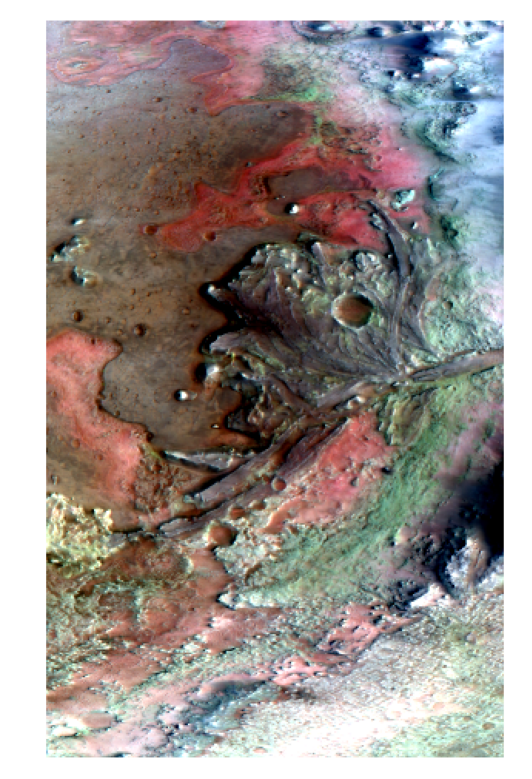

In [40]:
#mark super-pixel boundaries over the FCC and display it
plt.figure(dpi=200)
plt.imshow(fcc)
plt.axis('off')
plt.margins(0)

In [41]:
#import convex hull removal from pysptools
from pysptools.spectro import convex_hull_removal

In [42]:
#create a copy of the fcc
fccCopy=np.copy(fcc)

In [43]:
#set a threshold to identify flat spectra
#if minimum reflectance, for a spectrum after continuum removal, is > this threshold, it is considered a flat/unremarkable spectrum and ignored during further processing
flatSpectraThreshold=0.98

In [44]:
#create lists to hold the row columns and mediod spectra for each super-pixel
pixelRowsIndices=[]
pixelColsIndices=[]
pixelSpectra=[]

In [45]:
#preprocess the datacube for super-pixel segmentation
continumRemovedCube=np.full_like(imageLevelDespikedCube,-1e10)
normalizedContinuumRemovedCube=np.full_like(imageLevelDespikedCube,-1e10)
#set all out of scene pixels equal to -10^10 and normalize each in-scene pixel after removing its continuum
for j in tqdm(range(imageLevelDespikedCube.shape[1])):
    for i in range(imageLevelDespikedCube.shape[0]):
        #ignore out of scene pixels
        if np.all(imageLevelDespikedCube[i,j,:]==imageLevelDespikedCube[i,j,0]):
            pass
        else:
            #remove the continuum
            continumRemovedCube[i,j,:]=convex_hull_removal(imageLevelDespikedCube[i,j,:],wavelengthList)[0]
            #check if the spectrum is flat
            if np.amin(continumRemovedCube[i,j,:])>flatSpectraThreshold:
                fccCopy[i,j,:]=[255,255,255]
            #if not noramlize the spectrum
            else:
                normalizedContinuumRemovedCube[i,j,:]=continumRemovedCube[i,j,:]/np.linalg.norm(continumRemovedCube[i,j,:])
                pixelRowsIndices.append(i)
                pixelColsIndices.append(j)
                pixelSpectra.append(normalizedContinuumRemovedCube[i,j,:])

100%|████████████████████████████████████████████████████████████████████████████████| 320/320 [08:18<00:00,  1.56s/it]


In [46]:
#delete the convex_hull_removal method
del convex_hull_removal

In [47]:
#delete the continuum removed cubes to save memory
del continumRemovedCube

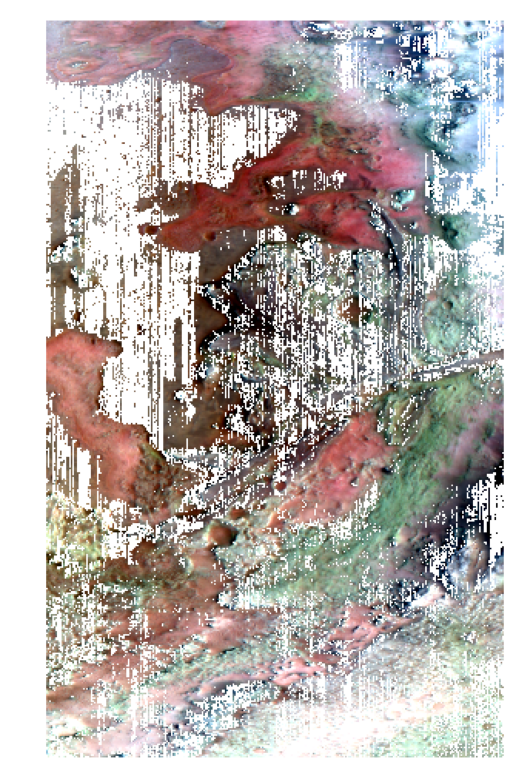

In [48]:
#mark super-pixel boundaries over the FCC and display it
plt.figure(dpi=200)
plt.imshow(fccCopy)
plt.axis('off')
plt.margins(0)

In [49]:
#load the models and classwise weibull parameters
closedSetclassifier,classwiseWeibullParameters=loadOpenModel()

In [50]:
#predict closed set labels and probability for the super-pixels
predictedPixelProba=closedSetclassifier.predict_proba(pixelSpectra)
predictedPixelLabels=np.argmax(predictedPixelProba,axis=-1)
predictedPixelProba=predictedPixelProba[np.arange(0,predictedPixelProba.shape[0],1),
                                        predictedPixelLabels]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 196.2min finished


In [51]:
#import weibull distribution from scipy
from scipy.stats import weibull_min as weibull

In [52]:
#create array to store open-set probabilities
predictedPixelOpenProba=np.zeros_like(predictedPixelProba)
#iterate through all the predicted labels
for currentClassLabel in tqdm(np.unique(predictedPixelLabels)):
    #predict open-set probability for the current class labels
    predictedPixelOpenProba[predictedPixelLabels==currentClassLabel]=weibull.cdf(predictedPixelProba[predictedPixelLabels==currentClassLabel],
                                                                                 *classwiseWeibullParameters[currentClassLabel])
    

100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 704.08it/s]


In [53]:
#delete the weibull distribution from memory
del weibull

In [54]:
predictedPixelOpenProba

array([1.11937165e-27, 9.80995097e-28, 8.87275646e-28, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [55]:
#import sqrt from math
from math import sqrt
#calculate the optimal probability threshold based on 'openness'
#no. of open/test classes=6
#no. of classes to be recognized=22
#no. of classes during evaluation=22+6=28
openness=1-sqrt(2*6/(22+28))
probabilityThreshold=0.5*openness #0.5 is chance

In [56]:
probabilityThreshold=0.38

In [57]:
#convert open-probabilities to labels
#predictedPixelOpenLabels=np.where(np.logical_or(predictedPixelOpenProba<probabilityThreshold,predictedPixelProba<probabilityThreshold),
predictedPixelOpenLabels=np.where(predictedPixelProba<probabilityThreshold,
                                  np.nan,
                                  predictedPixelLabels)

In [58]:
#create an array to hold the closed set mineral map
closedMineralMap=np.full_like(normalizedContinuumRemovedCube[:,:,0],np.nan)
#create an array to hold the closed set probabilities
closedProbabilityMap=np.full_like(normalizedContinuumRemovedCube[:,:,0],np.nan)
#create an array to hold the open set mineral map
openMineralMap=np.full_like(normalizedContinuumRemovedCube[:,:,0],np.nan)
#create an array to hold the open set probabilities
openProbabilityMap=np.full_like(normalizedContinuumRemovedCube[:,:,0],np.nan)

#convert labels and probabilites to maps
closedMineralMap[pixelRowsIndices,pixelColsIndices]=predictedPixelLabels
closedProbabilityMap[pixelRowsIndices,pixelColsIndices]=predictedPixelProba
openMineralMap[pixelRowsIndices,pixelColsIndices]=predictedPixelOpenLabels
openProbabilityMap[pixelRowsIndices,pixelColsIndices]=predictedPixelProba

In [59]:
#set probabilites for pixels wih no labels (in the open-regime) to nan
closedProbabilityMap[np.isnan(openMineralMap)]=np.nan
openProbabilityMap[np.isnan(openMineralMap)]=np.nan

In [60]:
#get the unique labels in the map
uniqueOpenMapLabels=np.sort(np.unique(openMineralMap)[:-1].astype('int32')).tolist()
mineralNames[uniqueOpenMapLabels]
uniqueMapLabels=uniqueOpenMapLabels

In [61]:
#import label (used to identify connected components) from scipy
from scipy.ndimage import label
#define the the fraction of pixels that must be present in the original image for the dilated component to be retained
connectedComponentFraction=1/2

#define the size of the dilation structuring element
dilationKernelSize=5
#define the size of the structuring element for detecting connected components
connectedComponentKernelSize=3
#specify the minimum size for a detection to be considered
minimumDetectionSize=5
#specify the minimum number of pixels (before post-processing) that must be present in a detection
minimumPixelsPerDetection=3

#import dilation from skimage
from skimage.morphology import dilation
#import square from skimage
from skimage.morphology import square

#define the footprint of the structuring element for dilation
dilationStructuringElement=square(dilationKernelSize)
#define the footprint of the structuring element for detecting connected components
connectedComponentStructuringElement=square(connectedComponentKernelSize)

C:\Users\sandy\.conda\envs\geospatial\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [62]:
#define a function which takes a binary map (0=Absent and 1=present), apply spatial constraints to it and return it
def applySpatialConstraintsToBinaryMap(binaryMap,dilationKernel,connectedComponentKernel,minimumSizePerDetection,connectedComponentFraction,minimumPixelsPerDetection):
    
    #label the connected componenets in the image
    connectedComponentMap,noOfComponents=label(binaryMap,connectedComponentKernel)
    
    #iterate through all the connected components and remove any that are entirely in a single column
    for currentConnectedComponentLabel in np.unique(connectedComponentMap):
        
        #get the indices of the pixels in the current connected component
        currentConnectedComponentRowIndices,currentConnectedComponentColIndices=np.where(connectedComponentMap==currentConnectedComponentLabel)
        #check if the component denotes absence of mineral or is entirely in a single column, then set it to nan, else set it to 1
        if binaryMap[currentConnectedComponentRowIndices,currentConnectedComponentColIndices][0]==0 or all(currentConnectedComponentColIndices==currentConnectedComponentColIndices[0]):
            binaryMap[currentConnectedComponentRowIndices,currentConnectedComponentColIndices]=0
        else:
            binaryMap[currentConnectedComponentRowIndices,currentConnectedComponentColIndices]=1
    
    
    #apply morphological dilation to the binary map
    dilatedMap=dilation(binaryMap,
                        footprint=dilationKernel)

    #label the connected componenets in the image
    connectedComponentMap,noOfComponents=label(dilatedMap,connectedComponentKernel)
    
    #create an array to hold the map after application of spatial constraints
    spatiallyConstraintedBinaryMap=np.full_like(binaryMap,np.nan).astype('float32')
    
    #iterate through each connected component
    for currentConnectedComponentLabel in np.unique(connectedComponentMap):
        
        #get the indices of the pixels in the current connected component
        currentConnectedComponentRowIndices,currentConnectedComponentColIndices=np.where(connectedComponentMap==currentConnectedComponentLabel)
        
        
        #if the component (after dilation) is entirely in a single column delete it
        if np.all(currentConnectedComponentColIndices==currentConnectedComponentColIndices[0]):
            spatiallyConstraintedBinaryMap[currentConnectedComponentRowIndices,currentConnectedComponentColIndices]=np.nan
        elif np.any(dilatedMap[currentConnectedComponentRowIndices,currentConnectedComponentColIndices]>0):
            
            #get the indices of the orginally detected pixels in the current connected component
            currentConnectedComponentsOriginalDetectionRelativeIndices=np.where(~np.isnan(binaryMap[currentConnectedComponentRowIndices,currentConnectedComponentColIndices]))[0]
            currentConnectedComponentsOriginalDetectionsRowIndices=currentConnectedComponentRowIndices[currentConnectedComponentsOriginalDetectionRelativeIndices]
            currentConnectedComponentsOriginalDetectionsColIndices=currentConnectedComponentColIndices[currentConnectedComponentsOriginalDetectionRelativeIndices]

            #if the component before dilation lay entirely in a single column delete it 
            if np.all(currentConnectedComponentsOriginalDetectionsColIndices==currentConnectedComponentsOriginalDetectionsColIndices[0]):
                spatiallyConstraintedBinaryMap[currentConnectedComponentRowIndices,currentConnectedComponentColIndices]=np.nan
                
            #if the size of the component is lesser than the threshold, delete it 
            elif len(currentConnectedComponentRowIndices)<minimumSizePerDetection:
                spatiallyConstraintedBinaryMap[currentConnectedComponentRowIndices,currentConnectedComponentColIndices]=np.nan
                
            #ignore connected components where the fraction of original detection is less than the threshold
            elif len(currentConnectedComponentsOriginalDetectionsRowIndices)/len(currentConnectedComponentRowIndices)<connectedComponentFraction:
                spatiallyConstraintedBinaryMap[currentConnectedComponentRowIndices,currentConnectedComponentColIndices]=np.nan
                
            #ignore connected components where the number of original detections is less than its threshold
            elif len(currentConnectedComponentsOriginalDetectionsRowIndices)<minimumPixelsPerDetection:
                spatiallyConstraintedBinaryMap[currentConnectedComponentRowIndices,currentConnectedComponentColIndices]=np.nan
            else:
                spatiallyConstraintedBinaryMap[currentConnectedComponentRowIndices,currentConnectedComponentColIndices]=1
    return spatiallyConstraintedBinaryMap

In [63]:
### define a function which takes the binary maps before and after applying spatial constrations as inputs, along with the probability values (before application of spatial constraints)
#it then computes the probability of pixels labelled by application of spatial constraints as the average probability of originally labelled pixels (before application of spatial constraints)
# in a 3X3 neighbourhood, if the number of originally labelled pixels in the 3X3 neighbourhood is <3 use a 5x5 neighbourhood
def assignProbabilitiesToNewPixels(constraintedDetectionMap,originalprobabilityMap):
    #create an array to hold the original probability values as well as those for the pixels introduced by the spatial constraints
    constraintedProbabilityMap=np.copy(originalprobabilityMap)
    
    #get indices of pixels which were introduced by the application spatial constraints
    originalPixelRowIndices,originalPixelColIndices=np.where(np.logical_and(np.isnan(originalprobabilityMap),~np.isnan(constraintedDetectionMap)))
    
    #iterate through all the pixels introduced by spatial constraints
    for i,j in zip(originalPixelRowIndices,originalPixelColIndices):
        #get probability values in the 3x3 neighbourhood around the current pixel
        temp=originalprobabilityMap[i-1:i+2,j-1:j+2][~np.isnan(originalprobabilityMap[i-1:i+2,j-1:j+2])]
        #check if 3 values are available, if not get values from a 5X5 neighourhood
        if temp.shape[0]<3:
            temp=originalprobabilityMap[i-2:i+3,j-2:j+3][~np.isnan(originalprobabilityMap[i-2:i+3,j-2:j+3])]
        #if no neighbours in a 5X% neighbourhood either, set the probability to 0
        if temp.shape[0]==0:
            temp=[0]
        #compute and save the probability as the average of the probabilities in the neighbourhood
        constraintedProbabilityMap[i,j]=np.median(temp)
    #return the updated probability map
    return constraintedProbabilityMap
        

In [64]:
#create a list contianing the labels of the minerals whose maps are to be displayed
mineralsToDisplay=[]

#create a numpy array which will hold the class-wise maps (arranged in ascending order of labels)
classWiseMaps=np.full((openMineralMap.shape[0],
                       openMineralMap.shape[1],
                       len(uniqueOpenMapLabels)),0).astype('float32')
#create a numpy array which will hold the class-wise probability maps (arragned in ascending order of labels)
classWiseProbabilityMaps=np.full((openMineralMap.shape[0],
                                  openMineralMap.shape[1],
                                  len(uniqueOpenMapLabels)),np.nan).astype('float32')
#create an array to hold class-wise maps after applying spatial constraints
spatiallyConstraintedClasswiseMaps=np.full_like(classWiseMaps,np.nan)
#create an array to hold class-wise probability maps after applying spatial constraints
spatiallyConstraintedClasswiseProbabilityMaps=np.full_like(classWiseMaps,np.nan)

In [65]:
#iterate through all the classes and apply spatial constraints and estimate probabilities (closed-set for) the pixels introduced by the 
for i in tqdm(range(len(uniqueOpenMapLabels))):
    #get the indices of having the current label
    currentLabelRowIndices,currentLabelColIndices=np.where(openMineralMap==uniqueOpenMapLabels[i])

    #populate the indices having the current map labels
    classWiseMaps[currentLabelRowIndices,currentLabelColIndices,i]=1
    
    
    #apply spatial constraints to the current class' binary map
    spatiallyConstraintedClasswiseMaps[:,:,i]=applySpatialConstraintsToBinaryMap(classWiseMaps[:,:,i],
                                                            dilationStructuringElement,
                                                            connectedComponentStructuringElement,
                                                            minimumDetectionSize,
                                                            connectedComponentFraction,
                                                            minimumPixelsPerDetection)
    
    #change the present label from 1 to the label of the current class
    spatiallyConstraintedClasswiseMaps[:,:,i][spatiallyConstraintedClasswiseMaps[:,:,i]==1]=uniqueOpenMapLabels[i]
    
    #remove any pixels deleted by spatial constraints from the classwise probability maps
    classWiseProbabilityMaps[:,:,i][spatiallyConstraintedClasswiseMaps[:,:,i]==uniqueOpenMapLabels[i]]=closedProbabilityMap[spatiallyConstraintedClasswiseMaps[:,:,i]==uniqueOpenMapLabels[i]]
    #estimate probabilities for pixels introduced by the spatial constraints using the 
    spatiallyConstraintedClasswiseProbabilityMaps[:,:,i]=assignProbabilitiesToNewPixels(spatiallyConstraintedClasswiseMaps[:,:,i],
                                                                                        classWiseProbabilityMaps[:,:,i])

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:05<00:00,  2.66it/s]


In [66]:
#create arrays to hold the multi-class label and probability maps generated by merging the spatially constrainted classwise maps together
spatiallyConstrainedMineralMap=np.full_like(spatiallyConstraintedClasswiseProbabilityMaps[:,:,0],np.nan)
spatiallyConstrainedProbabilityMap=np.full_like(spatiallyConstraintedClasswiseProbabilityMaps[:,:,0],np.nan)

In [67]:
#iterate through all classes and merge the maps using probability thresholds to resolve conflicts
#i.e. if a pixel (after applying spatial constraints) belongs to two or more classes, assign it to the class with the highest probability
for i in tqdm(range(len(uniqueOpenMapLabels))):
    #label pixel which have no labels so far, but belong to the current class
    spatiallyConstrainedMineralMap=np.where(np.logical_and(np.isnan(spatiallyConstrainedProbabilityMap),~np.isnan(spatiallyConstraintedClasswiseProbabilityMaps[:,:,i])),
                                            spatiallyConstraintedClasswiseMaps[:,:,i],spatiallyConstrainedMineralMap)
    spatiallyConstrainedProbabilityMap=np.where(np.logical_and(np.isnan(spatiallyConstrainedProbabilityMap),~np.isnan(spatiallyConstraintedClasswiseProbabilityMaps[:,:,i])),
                                                spatiallyConstraintedClasswiseProbabilityMaps[:,:,i],spatiallyConstrainedProbabilityMap)
    
    #check compare probabilities of pixels which already have a label and are assigned the current class
    rowIndices,colIndices=np.where(np.logical_and(~np.isnan(spatiallyConstrainedProbabilityMap),~np.isnan(spatiallyConstraintedClasswiseProbabilityMaps[:,:,i])))
    
    spatiallyConstrainedMineralMap[rowIndices,colIndices]=np.where(spatiallyConstraintedClasswiseProbabilityMaps[:,:,i][rowIndices,colIndices]>spatiallyConstrainedProbabilityMap[rowIndices,colIndices],
                                                                   spatiallyConstraintedClasswiseMaps[:,:,i][rowIndices,colIndices],
                                                                   spatiallyConstrainedMineralMap[rowIndices,colIndices])
    
    spatiallyConstrainedProbabilityMap[rowIndices,colIndices]=np.where(spatiallyConstraintedClasswiseProbabilityMaps[:,:,i][rowIndices,colIndices]>spatiallyConstrainedProbabilityMap[rowIndices,colIndices],
                                                                       spatiallyConstraintedClasswiseProbabilityMaps[:,:,i][rowIndices,colIndices],
                                                                       spatiallyConstrainedProbabilityMap[rowIndices,colIndices])

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 319.86it/s]


In [68]:
#delete the classwise maps to save memory
del classWiseMaps
del classWiseProbabilityMaps
del spatiallyConstraintedClasswiseMaps
del spatiallyConstraintedClasswiseProbabilityMaps

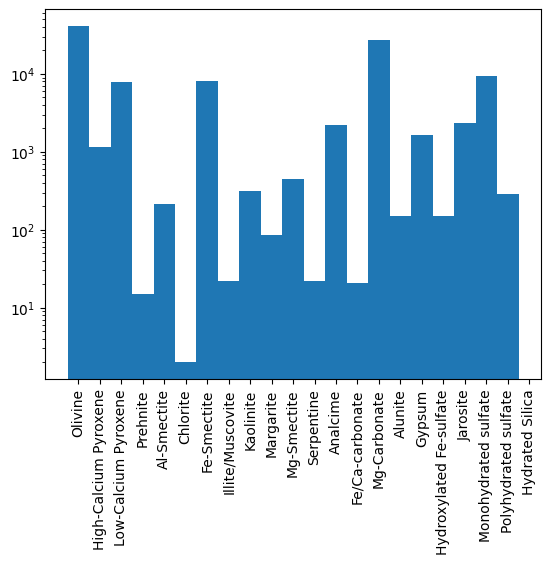

In [69]:
plt.hist(closedMineralMap[~np.isnan(closedMineralMap)],bins=np.arange(0,22,1),log=True)
k=plt.xticks(np.arange(0.5,22,1),labels=mineralNames,rotation='vertical')

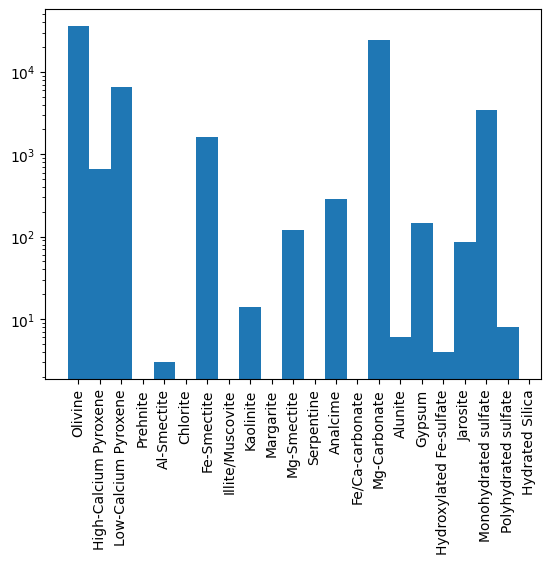

In [70]:
plt.hist(openMineralMap[~np.isnan(openMineralMap)],bins=np.arange(0,22,1),log=True)
k=plt.xticks(np.arange(0.5,22,1),labels=mineralNames,rotation='vertical')

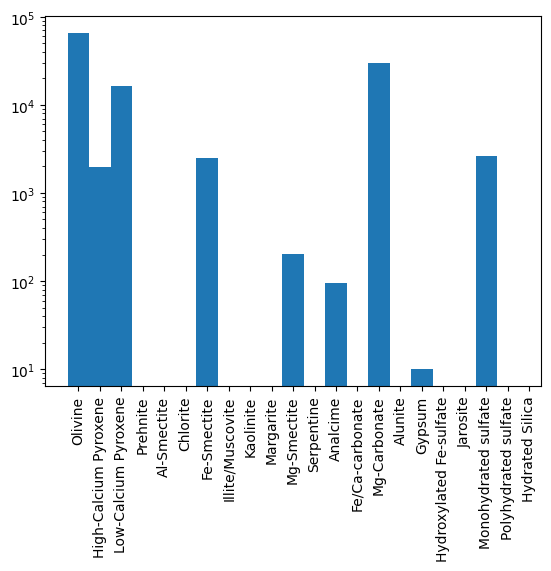

In [71]:
plt.hist(spatiallyConstrainedMineralMap[~np.isnan(spatiallyConstrainedMineralMap)],bins=np.arange(0,22,1),log=True)
k=plt.xticks(np.arange(0.5,22,1),labels=mineralNames,rotation='vertical')

In [72]:
#removes detections whose size is less than a desired threshold
#removes detections whose median probability is less than a desired threshold
#returns the updated map, along with a dictionary containing the locations, label, probability, and mean spectra of connected component

#create a numpy array which will hold the class-wise maps (arranged in ascending order of labels)
classWiseMaps=np.full((openMineralMap.shape[0],
                       openMineralMap.shape[1],
                       len(uniqueOpenMapLabels)),0).astype('float32')
#get the labels present in the map after applying spatial constraints
uniqueOpenMapLabels=np.unique(spatiallyConstrainedMineralMap)[:-1]


In [73]:
#set probability threshold for detection
detectionProbabilityThreshold=0.38

In [74]:
#create a list to hold dictionary elements, each describing a specific detection/connected component
mineralDetections=[]

#iterate through all the classes and apply spatial constraints and estimate probabilities (closed-set for) the pixels introduced by the 
for i in tqdm(range(len(uniqueOpenMapLabels))):
    #get the indices of having the current label
    currentLabelRowIndices,currentLabelColIndices=np.where(spatiallyConstrainedMineralMap==uniqueOpenMapLabels[i])
    #create a binary map for the current class
    classWiseMaps[currentLabelRowIndices,currentLabelColIndices,i]=1
    #label the connected componenets in the image
    connectedComponentMap,noOfComponents=label(classWiseMaps[:,:,i],connectedComponentStructuringElement)
    
    #iterate through each connected component
    for currentConnectedComponentLabel in np.unique(connectedComponentMap):
        
        #get the indices of the pixels in the current connected component
        currentConnectedComponentRowIndices,currentConnectedComponentColIndices=np.where(connectedComponentMap==currentConnectedComponentLabel)
        #skip components that denote absence
        if np.all(classWiseMaps[currentConnectedComponentRowIndices,currentConnectedComponentColIndices,i]==0):
            continue
        #compute median probability of the component
        componentProbability=np.median(spatiallyConstrainedProbabilityMap[currentConnectedComponentRowIndices,currentConnectedComponentColIndices])
        #remove components smaller than a threshold
        if len(currentConnectedComponentColIndices)<minimumDetectionSize:
            classWiseMaps[currentConnectedComponentRowIndices,currentConnectedComponentColIndices,i]=0
        #as well as those those probability is less than a threshold or nan
        if componentProbability<detectionProbabilityThreshold or componentProbability==np.nan:
            classWiseMaps[currentConnectedComponentRowIndices,currentConnectedComponentColIndices,i]=0
        #save the component and its description
        else:
            #compute the mean spectrum of the detection
            currentDetectionSpectra=imageLevelDespikedCube[currentConnectedComponentRowIndices,currentConnectedComponentColIndices,:]
            temp=[]
            for j in range(currentDetectionSpectra.shape[0]):
                if np.ptp(currentDetectionSpectra[j,:])>0:
                    temp.append((currentDetectionSpectra[j,:]-np.amin(currentDetectionSpectra[j,:]))/np.ptp(currentDetectionSpectra[j,:]))
            if len(temp)==0:
                continue
            currentDetectionSpectra=np.vstack(temp)
            del temp
            currentDetection={'rowIndices':currentConnectedComponentRowIndices,
                              'colIndices':currentConnectedComponentColIndices,
                              'probability':componentProbability,
                              'label':uniqueOpenMapLabels[i],
                              'meanSpectrum':np.mean(currentDetectionSpectra,axis=0)}
            mineralDetections.append(currentDetection)
    

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.73it/s]


In [75]:
#create a mineral map from the detections retained
finalMineralMap=np.full_like(spatiallyConstrainedMineralMap,np.nan)
for i in tqdm(range(len(mineralDetections))):
    finalMineralMap[mineralDetections[i]['rowIndices'],mineralDetections[i]['colIndices']]=mineralDetections[i]['label']

100%|██████████████████████████████████████████████████████████████████████████████████████| 1294/1294 [00:00<?, ?it/s]


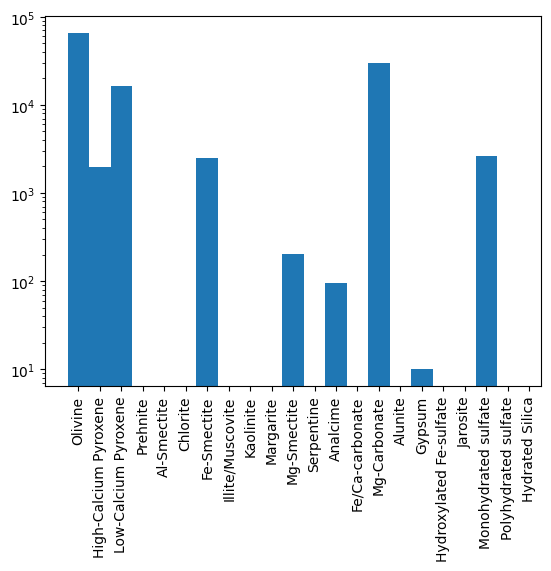

In [76]:
plt.hist(finalMineralMap[~np.isnan(finalMineralMap)],bins=np.arange(0,22,1),log=True)
k=plt.xticks(np.arange(0.5,22,1),labels=mineralNames,rotation='vertical')

In [77]:
#import gdal to read the images
from osgeo import gdal

In [78]:
#read the trdr file
outputFile=gdal.Open(outputfileAddress,gdal.GA_Update)

In [79]:
outputfileAddress

'D:/Mars/MachineLearning/Datasets/CRISMImages/TRDRs/40FF/hrl000040ff_07_if183l_trr3_CAT_Four_Level_MineralMap_WESVM.img'

In [80]:
#write the closed set output
currentBand=outputFile.GetRasterBand(1)
flag=currentBand.WriteArray(closedMineralMap)
print(flag)
currentBand.FlushCache()
currentBand=None

0


In [81]:
#write the open set output
currentBand=outputFile.GetRasterBand(2)
flag=currentBand.WriteArray(openMineralMap)
print(flag)
currentBand.FlushCache()
currentBand=None

0


In [82]:
#write the post-processed output
currentBand=outputFile.GetRasterBand(3)
flag=currentBand.WriteArray(spatiallyConstrainedMineralMap)
print(flag)
currentBand.FlushCache()
currentBand=None

0


In [83]:
#write the post-processed output
currentBand=outputFile.GetRasterBand(4)
flag=currentBand.WriteArray(finalMineralMap)
print(flag)
currentBand.FlushCache()
currentBand=None

0


In [84]:
#ensure the data is saved by flushing the denoised file from the cache
outputFile.FlushCache()
outputFile=None

In [85]:
#read the trdr file
outputFile=gdal.Open(flatoutedFCCAddress,gdal.GA_Update)

In [86]:
flatoutedFCCAddress

'D:/Mars/MachineLearning/Datasets/CRISMImages/TRDRs/40FF/hrl000040ff_07_if183l_trr3_CAT_RGB_NonFlat.img'

In [87]:
#write the closed set output
currentBand=outputFile.GetRasterBand(1)
flag=currentBand.WriteArray(fccCopy[:,:,0])
print(flag)
currentBand.FlushCache()
currentBand=None

0


In [88]:
#write the open set output
currentBand=outputFile.GetRasterBand(2)
flag=currentBand.WriteArray(fccCopy[:,:,1])
print(flag)
currentBand.FlushCache()
currentBand=None

0


In [89]:
#write the open set output
currentBand=outputFile.GetRasterBand(3)
flag=currentBand.WriteArray(fccCopy[:,:,2])
print(flag)
currentBand.FlushCache()
currentBand=None

0


In [90]:
#ensure the data is saved by flushing the denoised file from the cache
outputFile.FlushCache()
outputFile=None

In [91]:
#import pickle to save the detection details
import pickle

In [92]:
#save the detection details to the disk
with open(detectionDetailsAddress,'wb') as f:
    pickle.dump(mineralDetections,f)

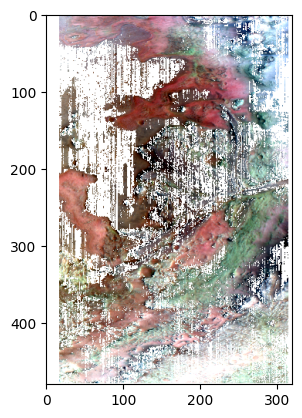

In [93]:
plt.imshow(fccCopy)